# Short term FFT of an audio signal

In [1]:
import numpy as np
import scipy.io.wavfile as wav
import time
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib notebook

In [2]:
# load the .wav file

sample_rate, samples = wav.read('happy.wav')

########### OPTIONAL ####################
# ADAPT THIS TO YOUR OWN RECORDING

start_ind = int(round(.5*len(samples)))
end_ind = int(round(.95*len(samples)))
samples = samples[start_ind:end_ind]
#########################################

n_samples = len(samples)

Function to perform windowing over the sound wave.

In [3]:
def windowing(signal,sample_rate,frame_size, window_fun = np.hanning, overlap = 0.5):

    if frame_size > len(samples):
        print('Be careful, your frame size is larger than your sample size')
    
    n_samples = len(samples)
    length = n_samples/sample_rate
    t = np.linspace(0,length,n_samples)
    dt = t[1]
    
    window = window_fun(frame_size)
    
    stride_length = int(frame_size - np.floor(overlap*frame_size))

    # append zeros at beginning of the domain 
    # so that the crest of the 1st window coindices with the first sample
    samples_left_pad = np.append(np.zeros(int(np.floor(frame_size/2.0)) ), samples)   

    t_left_pad = np.append(np.linspace(-int(np.floor(frame_size/2.0))*dt,
                                       -t[1],int(np.floor(frame_size/2.0))),t)

    # number of windowing frames
    n_frames = int(np.ceil((len(samples_left_pad) - frame_size) / float(stride_length))) + 1

    # append zeros at the end of the domain in case the window oversteps the boundary
    samples_pad = np.append(samples_left_pad, np.zeros(int(np.ceil(frame_size/2.0)) ))

    t_pad = np.append(t_left_pad, 
                      np.linspace(t[-1],t[-1]+int(np.ceil(frame_size/2.0))*dt,
                                  int(np.ceil(frame_size/2.0)) ))

    frames = np.lib.stride_tricks.as_strided(samples_pad, 
                                             shape=(n_frames, frame_size), 
                                             strides=(samples_pad.strides[0]*stride_length, 
                                             samples_pad.strides[0])).copy()

    t_frames = np.lib.stride_tricks.as_strided(t_pad, 
                                             shape=(n_frames, frame_size), 
                                             strides=(t_pad.strides[0]*stride_length, 
                                             t_pad.strides[0])).copy()
    
    return samples_pad, t_pad, window, frames, t_frames

Now we can proceed to obtain the so called short term Discrete Fourier Transform of the local product ofthe window and the signal using the FFT algorithm. 

The plotting script shows result of the product of the window by the signal for each frame, as well as the frequencies obtained using the FFT algorithm.

<IPython.core.display.Javascript object>


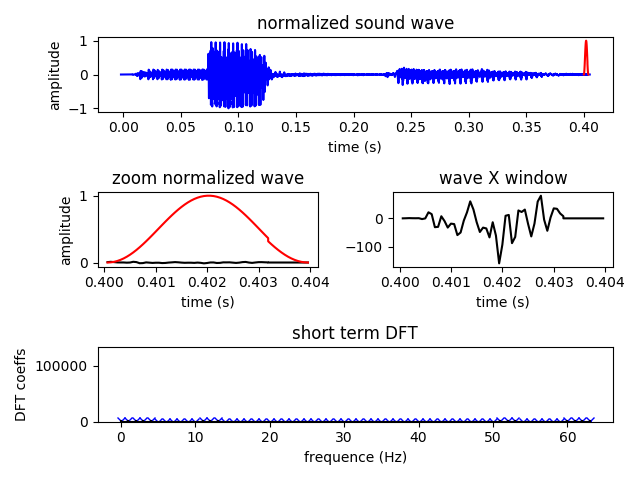

In [4]:
frame_size = 2**6
samples_pad, t_pad, window, frames, t_frames = windowing(samples,sample_rate,frame_size)

window_frames = frames*window
n_frames = t_frames.shape[0]

# fast fourier transform
sfft = np.fft.fft(window_frames)

fig, ax = plt.subplots()
max_samples = np.max(abs(samples_pad))

plt.subplot(311)
signal_plot = plt.plot(t_pad,samples_pad/max_samples,color = 'b')
plt.title('normalized sound wave')

for i in range(n_frames):  
    
    if i is not 0:
        window_plot[0].remove()
    plt.subplot(311)
    window_plot = plt.plot(t_frames[i,:],
                           window,color = 'r')    
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')

    plt.subplot(323)    
    if i is not 0:
        plt.cla()
    plot_frames = plt.plot(t_frames[i,:],frames[i,:]/max_samples,color = 'k')    
    plot_samples_padded = plt.plot(t_frames[i,:],window,color = 'r')      
    plt.title('zoom normalized wave')    
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')

    plt.subplot(324)        
    if i is not 0:       
        plt.cla()
    plot_win_frames = plt.plot(t_frames[i,:],window_frames[i,:],color = 'k')
    plt.title('wave X window') 
    plt.xlabel('time (s)')

    plt.subplot(313)        
    if i is not 0:
        plt.cla()          
    plot_win_frames = plt.stem(abs(sfft[i,:]),linefmt='k-', markerfmt='bx', basefmt='k')
    plt.title('short term DFT')   
    plt.xlabel('frequence (Hz)')
    plt.ylabel('DFT coeffs')
    plt.ylim(0,1.1*np.max(abs(sfft)))

    fig.canvas.draw()
    plt.tight_layout()
    time.sleep(1/n_frames)

<IPython.core.display.Javascript object>


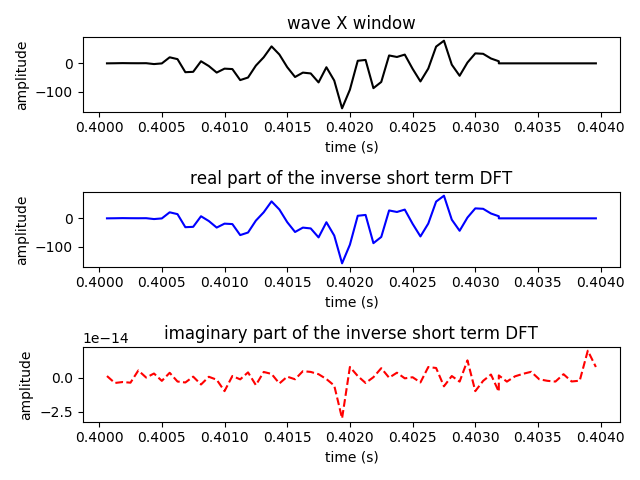

In [8]:
fig, ax = plt.subplots()

for i in range(n_frames):  
    isftt = np.fft.ifft(sfft[i,:])
    plt.subplot(311)        
    if i is not 0:       
        plt.cla()
    plot_win_frames = plt.plot(t_frames[i,:],window_frames[i,:],color = 'k')
    plt.title('wave X window') 
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    
    plt.subplot(312)        
    if i is not 0:
        plt.cla()          
    plot_win_frames = plt.plot(t_frames[i,:],isftt.real,'-b')
    plt.title('real part of the inverse short term DFT')   
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')

    plt.subplot(313)        
    if i is not 0:
        plt.cla()          
    plot_win_frames = plt.plot(t_frames[i,:],isftt.imag,'--r')
    plt.title('imaginary part of the inverse short term DFT')   
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    
    
    fig.canvas.draw()
    plt.tight_layout()
    time.sleep(1/n_frames)

The reconstructed signal matches exactly the original (up to rounding errors). Since the size of the frames is even, the amplitude of the imaginary parts are 0, up to round off errors. In practice we use the [rftt](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.fft.rfft.html) function, and only plot half of the values, since the other half are identical by symmetry.

<IPython.core.display.Javascript object>


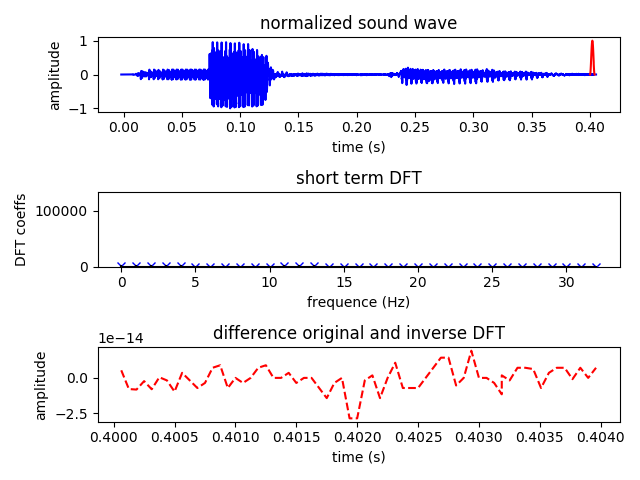

In [6]:
srfft = np.fft.rfft(window_frames)

fig, ax = plt.subplots()

plt.subplot(311)
signal_plot = plt.plot(t_pad,samples_pad/max_samples,color = 'b')
plt.title('normalized sound wave')

for i in range(n_frames):  

    isrftt = np.fft.irfft(srfft[i,:])
    if i is not 0:
        window_plot[0].remove()
    plt.subplot(311)
    window_plot = plt.plot(t_frames[i,:],
                           window,color = 'r')    
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    
    plt.subplot(312)        
    if i is not 0:
        plt.cla()          
    plot_win_frames = plt.stem(abs(srfft[i,:]),linefmt='k-', markerfmt='bx', basefmt='k')
    plt.title('short term DFT')   
    plt.xlabel('frequence (Hz)')
    plt.ylabel('DFT coeffs')
    plt.ylim(0,1.1*np.max(abs(srfft)))

    plt.subplot(313)        
    if i is not 0:
        plt.cla()          
    plot_win_frames = plt.plot(t_frames[i,:],window_frames[i,:]-isrftt.real,'--r')
    plt.title('difference original and inverse DFT')   
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    
    
    fig.canvas.draw()
    plt.tight_layout()
    time.sleep(1/n_frames)